# Projeto 11: Transfer learning para identificação de objetos  

- Neste projeto, vamos utilizar uma rede neural pré-treinada chamada MobileNet
- Utilizaremos a base de dados TensorFlow Flowers 
- Código baseado na documentação abaixo: 
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras


# Etapa 1: Importação das bibliotecas

In [1]:
#%tensorflow_version 2.x#google colab
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
tf.__version__

'2.1.0'

In [2]:
#!pip3.6 install tensorflow_hub --upgrade
import tensorflow_hub as hub

# Etapa 2: Importação do modelo pré-treinado

In [3]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url, 
                                                        input_shape=(224,224,3))])

# Etapa 3: Testes com o modelo pré-treinado

In [5]:
#Google colab
"""import zipfile
path = "/content/drive/My Drive/Colab Notebooks/transferlearn.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("/content/drive/My Drive/Colab Notebooks/02_projeto_objetos_flores")
zip_object.close()"""

'import zipfile\npath = "/content/drive/My Drive/Colab Notebooks/transferlearn.zip"\nzip_object = zipfile.ZipFile(file=path, mode="r")\nzip_object.extractall("/content/drive/My Drive/Colab Notebooks/02_projeto_objetos_flores")\nzip_object.close()'

In [7]:
sample_image= tf.keras.preprocessing.image.load_img(r'./Transfer Learning Data/watch.jpg', 
                                                    target_size = (224, 224))

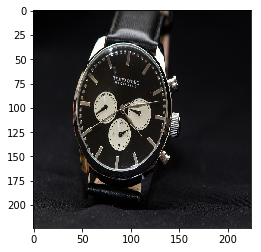

In [8]:
plt.imshow(sample_image)

In [9]:
sample_image = np.array(sample_image) / 255.0

In [10]:
sample_image.shape

(224, 224, 3)

In [11]:
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

In [12]:
predicted_class

array([[ 0.31899288,  0.69766086, -0.4810167 , ...,  0.22585607,
        -1.4412363 , -0.02521691]], dtype=float32)

In [13]:
len(predicted_class[0])

1001

In [14]:
predicted_class.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(predicted_class)
predicted_class

827

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

16384/10484 [==============================================] - 0s 0us/step


In [17]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [18]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [19]:
len(imagenet_labels)

1001

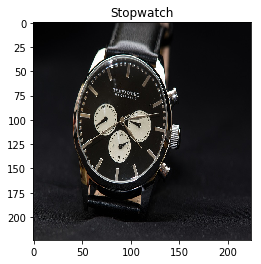

In [20]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

# Etapa 4: Testes com um conjunto de imagens

In [21]:
flowers_data_url = tf.keras.utils.get_file('flower_photos', 
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

120520704/228813984 [==============>...............] - ETA: 1:17

KeyboardInterrupt: 

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

In [ ]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

In [ ]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

In [ ]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flower_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Etapa 5: Transfer learning

Download do MobileNet sem o topo do modelo:
https://tfhub.dev/s?module-type=image-feature-vector&q=tf2


In [ ]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [ ]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))

In [ ]:
feature_batch = MobileNet_feature_extractor_layer(flower_data_input_batch)
feature_batch.shape

In [ ]:
MobileNet_feature_extractor_layer.trainable = False

In [ ]:
flower_data.num_classes

In [ ]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])

In [ ]:
model.summary()

In [ ]:
predictions = model(flower_data_input_batch)
predictions.shape

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(flower_data, epochs=50)

# Etapa 6: Avaliação do modelo

In [ ]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [ ]:
class_names

In [ ]:
class_names = np.array([key.title() for key, value in class_names])

In [ ]:
class_names

In [ ]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
predicted_id

In [ ]:
predicted_label_batch

In [ ]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')